In [1]:
#Add repo path to the system path
from pathlib import Path, PurePosixPath
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Libraries
import pandas as pd
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    InterpolationMode,
)
from PIL import Image
from matplotlib import pyplot as plt
import monai.transforms


# extra imports
sys.path.append(str(repo_path / 'SAMed'))
from SAMed.utils import DiceLoss, Focal_loss
from SAMed.segment_anything import build_sam, SamPredictor
from SAMed.segment_anything import sam_model_registry
from SAMed.segment_anything.modeling import Sam

# for logging in notebook
import logging
import sys
date_strftime_format = "%m/%d/%Y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Some visualization

We prepare the data<br>
- The first approach for segmentation is SAMed in 2D, so the 3D slices with lesion are saved as png or mha.
The idea is to save the 2D with this name: <br>
patient_id + slice_number + label + .png <br>

Check all images shapes, spacing, etc. <br>
For that, we create an extended metadata file.<br>
-> The extended metadata file is created with the script: extended_metadata.py<br>   

After creating the extended metadata we get the following information:<br>
- All images have the same spacing: [1.0, 1.0, 1.0], origin [0.0, 0.0, 0.0] and direction [[1. 0. 0.] [0. 1. 0.] [0. 0. 1.]].
- The images have 11 different shapes: resizing is an essential step at some point.
- Min and max values per axis (z,y,x): ([330, 546, 843], [354, 682, 865])<br>

So essentially, the number of z-slides is the same, and the image ratio changes a little bit. <br>

Read the images in their original nrrd format

In [2]:
# define paths, get list of images and labels and split them into train and test
experiment_path = repo_path / 'experiments/SAMed_ABUS'
root_path = repo_path / 'data/challange_2023/Train'

# get list of images using metadata
metadata = pd.read_csv(root_path / 'extended_metadata.csv')

In [31]:
# get example image
idx = 0
row = metadata.iloc[idx]
# paths
image_path = root_path /  row['data_path']
mask_path = root_path /  row['mask_path']
# read
im = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
label = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
# info
print(f'shape of image: {im.shape}')
print(f'label values: {np.unique(label)}')

# we need to find z values for the mask that have a label
z_values = np.unique(np.where(label)[0])
print(f'z values with label: {z_values.shape[0]}')

shape of image: (330, 608, 865)
label values: [0 1]
z values with label: 36


(-0.5, 864.5, 607.5, -0.5)

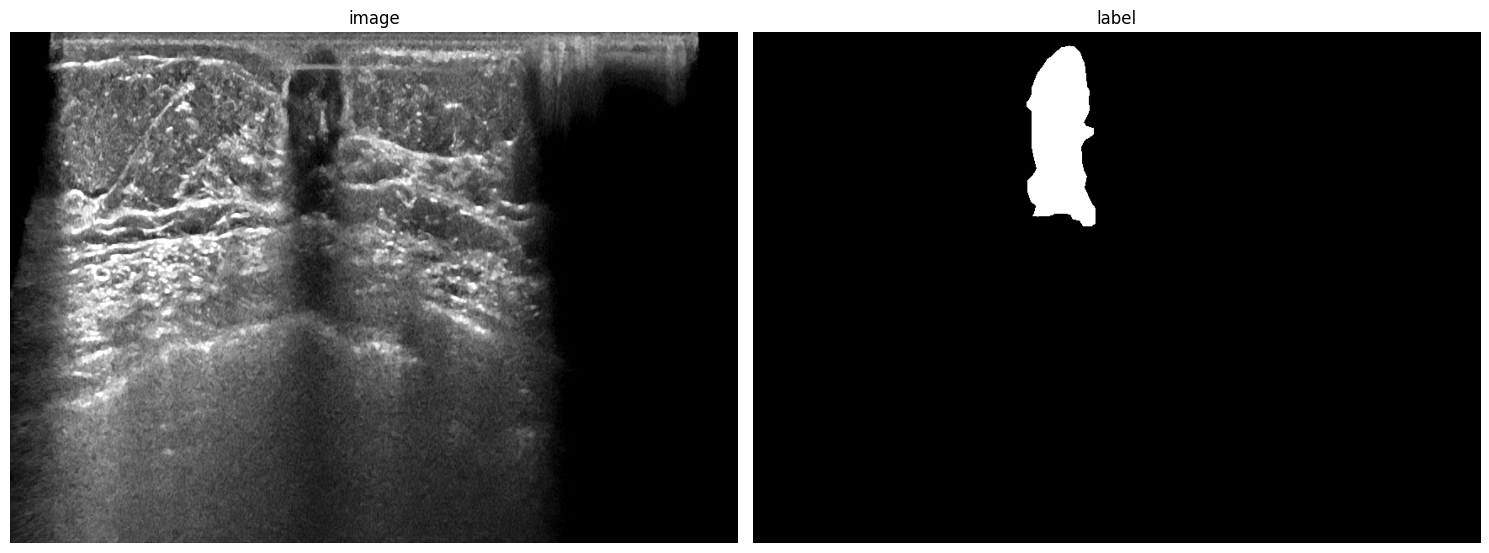

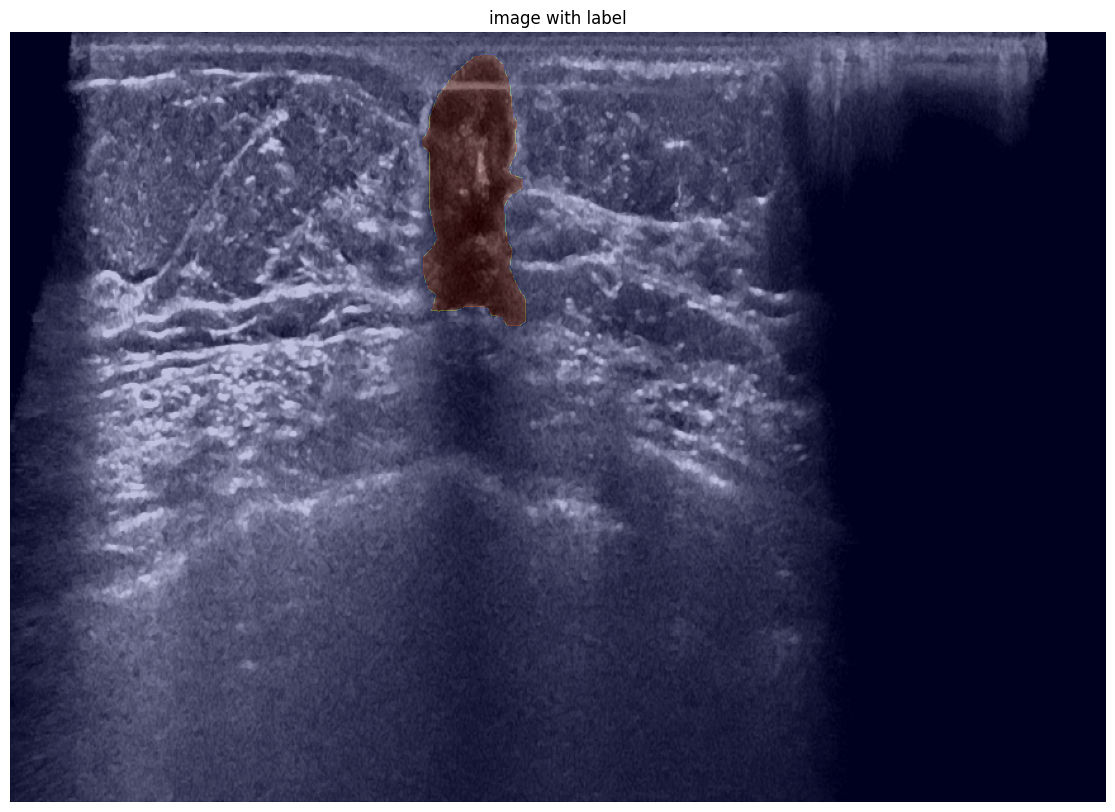

In [32]:
# show slide of image and mask in z
z = z_values[18]
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(im[z,:,:], cmap='gray')
ax[0].set_title('image')
ax[1].imshow(label[z,:,:], cmap='gray')
ax[1].set_title('label')
# remove axis
for a in ax:
    a.axis('off')
fig.tight_layout()

# same but with the lesion on top
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.imshow(im[z,:,:], cmap='gray')
ax.imshow(label[z,:,:], cmap='jet', alpha=0.25)
ax.set_title('image with label')
ax.axis('off')

# Saving pipeline for lesion-only slices

In [7]:
# define paths, get list of images and labels and split them into train and test
root_path = repo_path / 'data/challange_2023/Train'

# new images and labels
save_dir = repo_path / 'data/challange_2023' / 'only_lesion'
save_dir.mkdir(exist_ok=True)
im_dir = save_dir / 'images'
im_dir.mkdir(exist_ok=True)
label_dir = save_dir / 'labels'
label_dir.mkdir(exist_ok=True)

# get list of images using metadata
metadata = pd.read_csv(root_path / 'labels.csv')

# get example image
idx = 0
row = metadata.iloc[idx]
# image files, replace \\ with /
image_path = root_path /  row['data_path'].replace('\\', '/')
label_path = root_path / row['mask_path'].replace('\\', '/')
# get image and label
im = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))

#  # z values valid lesion
# z_values = np.unique(np.where(label)[0])
# for z in z_values:
#     # saving path
#     save_name = f'id_{row["case_id"]}_slice_{z}_label_{row["label"]}.mha'
#     # save image
#     sitk.WriteImage(sitk.GetImageFromArray(im[z,:,:]), str(im_dir / save_name))
#     # save label
#     sitk.WriteImage(sitk.GetImageFromArray(label[z,:,:]), str(label_dir / save_name))
    

## Check saved images

Text(0.5, 1.0, 'label')

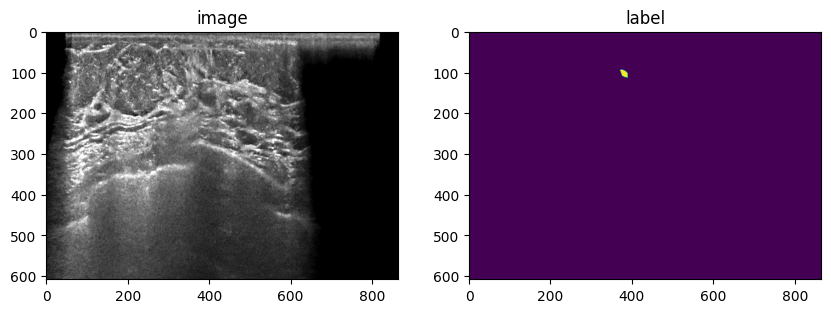

In [8]:
# read images to check they are ok, in alphabetical order
im_files = sorted(list(im_dir.glob('*.mha')))
label_files = sorted(list(label_dir.glob('*.mha')))
# show
idx = 0
label_read = sitk.GetArrayFromImage(sitk.ReadImage(str(label_files[idx])))
im_read = sitk.GetArrayFromImage(sitk.ReadImage(str(im_files[idx])))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(im_read, cmap='gray')
ax[0].set_title('image')
ax[1].imshow(label_read)
ax[1].set_title('label')

# Actual saving implementation

Correction to previous slide saving: <br>
SAM outputs a low resolution mask that is latter decoded to the original resolution. This in importnat because we have to ensure that the low resolution mask preserves lesion pixels. <br>
Otherwise, during training time the model will be confused by the low resolution mask loss computing. <br>

In [5]:
# HP
resolution = 256
stopping = None

preprocess_im = Compose(
        [ # classic squared aspect-preserved centered image
            Resize(resolution, interpolation= InterpolationMode.BILINEAR),
            CenterCrop(resolution), 
        ]
)

preprocess_label = Compose(
        [ # classic squared aspect-preserved centered image
            Resize(resolution, interpolation= InterpolationMode.NEAREST),
            CenterCrop(resolution), 
        ]
)

# low_res_trans = monai.transforms.Compose([monai.transforms.Resized(keys=["label"], spatial_size=(64, 64),mode=['nearest'])])
low_res_trans = Compose(
        [ # classic squared aspect-preserved centered image
            Resize(64, interpolation= InterpolationMode.NEAREST),
            CenterCrop(64), 
        ]
)

In [25]:
# define paths, get list of images and labels and split them into train and test
root_path = repo_path / 'data/challange_2023/Train'

# new images and labels directories
save_dir = repo_path / 'data/challange_2023' / 'only_lesion'
save_dir.mkdir(exist_ok=True)
im_dir = save_dir / 'images'
im_dir.mkdir(exist_ok=True)
label_dir = save_dir / 'labels'
label_dir.mkdir(exist_ok=True)

# get list of images using metadata
metadata = pd.read_csv(root_path / 'extended_metadata.csv')

iter = tqdm(metadata.iterrows(), total=len(metadata))
# get example image
for i, row in metadata.iterrows():    
    image_path = root_path /  row['data_path']
    label_path = root_path / row['mask_path']
    # get image and label
    im = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
    label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))

    # z values valid lesion
    z_values = np.unique(np.where(label)[0])
    for z in z_values:
        # preprocess image
        im_slice = Image.fromarray(im[z])
        im_slice = preprocess_im(im_slice)
        im_slice = np.asarray(im_slice)
        # # put channel first and repeat
        im_slice = np.repeat(np.expand_dims(im_slice, axis=0), 3, axis=0)

        # preprocess label
        label_slice = Image.fromarray(label[z])
        label_slice = preprocess_label(label_slice)
        low_label_slice = low_res_trans(label_slice)
        low_label_slice = np.asarray(low_label_slice)
        label_slice = np.asarray(label_slice)
        
        # check if there is still a lesion
        if not np.any(label_slice): # it could disappear after preprocessing
            print(f'Nothing in the label. id; {row["case_id"]}, slice: {z}')
            continue
        if not np.any(low_label_slice): # it could disappear after low resolution
            print(f'Nothing in the low label. id; {row["case_id"]}, slice: {z}')
            continue
    
        # saving path
        save_name = f'id_{row["case_id"]}_slice_{z}_label_{row["label"]}.mha'
        # save image
        sitk.WriteImage(sitk.GetImageFromArray(im_slice), str(im_dir / save_name))
        # save label
        sitk.WriteImage(sitk.GetImageFromArray(label_slice), str(label_dir / save_name))

    iter.update(1)
    # emergency stop
    if i == stopping:
        break

  9%|▉         | 9/100 [00:32<05:31,  3.65s/it]


  9%|▉         | 9/100 [00:19<03:28,  2.29s/it]

Nothing in the low label. id; 8, slice: 232
Nothing in the low label. id; 8, slice: 233


 11%|█         | 11/100 [00:24<03:34,  2.41s/it]

Nothing in the low label. id; 10, slice: 204


 22%|██▏       | 22/100 [00:51<03:09,  2.43s/it]

Nothing in the low label. id; 21, slice: 263


 27%|██▋       | 27/100 [01:01<02:35,  2.12s/it]

Nothing in the low label. id; 26, slice: 146


 48%|████▊     | 48/100 [01:49<01:58,  2.27s/it]

Nothing in the low label. id; 47, slice: 186


 50%|█████     | 50/100 [01:54<01:53,  2.27s/it]

Nothing in the low label. id; 49, slice: 203


 54%|█████▍    | 54/100 [02:02<01:43,  2.24s/it]

Nothing in the low label. id; 53, slice: 225


 58%|█████▊    | 58/100 [02:11<01:32,  2.21s/it]

Nothing in the low label. id; 57, slice: 217


 62%|██████▏   | 62/100 [02:21<01:30,  2.39s/it]

Nothing in the low label. id; 61, slice: 152


 69%|██████▉   | 69/100 [02:36<01:05,  2.11s/it]

Nothing in the low label. id; 68, slice: 208


 70%|███████   | 70/100 [02:39<01:06,  2.22s/it]

Nothing in the low label. id; 69, slice: 266


 71%|███████   | 71/100 [02:41<01:07,  2.32s/it]

Nothing in the low label. id; 70, slice: 142


 78%|███████▊  | 78/100 [02:58<00:51,  2.36s/it]

Nothing in the low label. id; 77, slice: 256
Nothing in the low label. id; 77, slice: 257


 81%|████████  | 81/100 [03:04<00:42,  2.22s/it]

Nothing in the low label. id; 80, slice: 237


 83%|████████▎ | 83/100 [03:08<00:34,  2.02s/it]

Nothing in the low label. id; 82, slice: 178


 96%|█████████▌| 96/100 [03:37<00:09,  2.33s/it]

Nothing in the low label. id; 95, slice: 207


 99%|█████████▉| 99/100 [03:43<00:02,  2.30s/it]

Nothing in the low label. id; 98, slice: 249


100%|██████████| 100/100 [03:45<00:00,  2.21s/it]

# Checking low resolution mask

In [15]:
# define paths, get list of images and labels and split them into train and test
root_path = repo_path / 'data/challange_2023/Train'
metadata = pd.read_csv(root_path / 'extended_metadata.csv')

# get example image
row = metadata.iloc[10]
image_path = root_path /  row['data_path']
label_path = root_path / row['mask_path']
# get image and label
im = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))

Text(0.5, 1.0, 'low label')

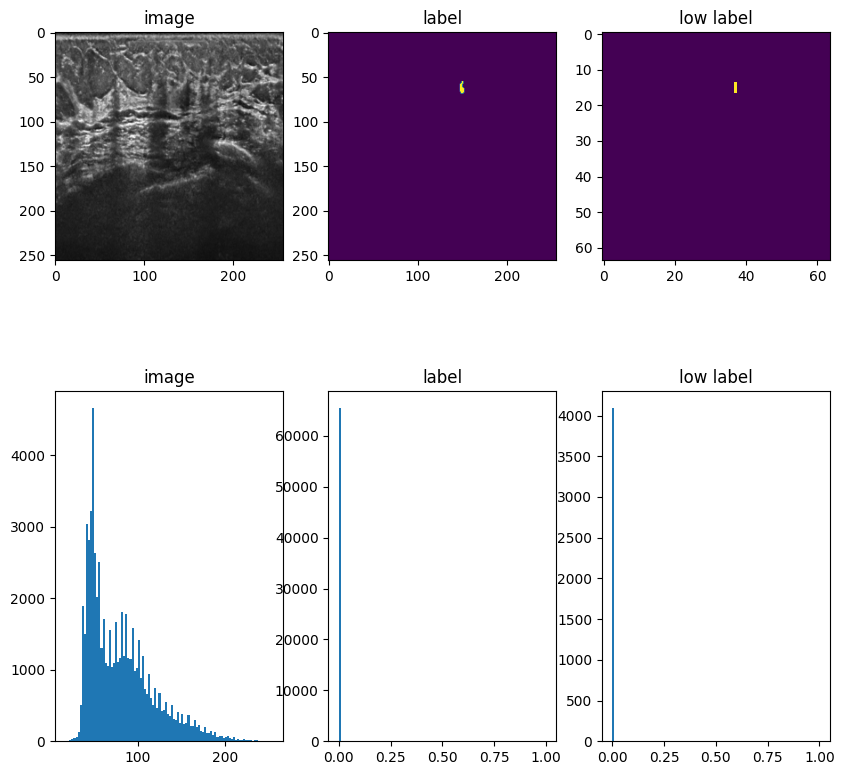

In [17]:
low_res_trans = monai.transforms.Compose([monai.transforms.Resized(keys=["label"], spatial_size=(64, 64),mode=['nearest'])])
low_res_trans = Compose(
        [ # classic squared aspect-preserved centered image
            Resize(64, interpolation= InterpolationMode.NEAREST),
            CenterCrop(64), 
        ]
)

# z values valid lesion
z_values = np.unique(np.where(label)[0])
z = z_values[1]
# preprocess image
im_slice = Image.fromarray(im[z])
im_slice = preprocess_im(im_slice)
im_slice = np.asarray(im_slice)
# # put channel first and repeat
im_slice = np.repeat(np.expand_dims(im_slice, axis=0), 3, axis=0)

# preprocess label
label_slice = Image.fromarray(label[z])
label_slice = preprocess_label(label_slice)
low_label_slice = low_res_trans(label_slice)
low_label_slice = np.asarray(low_label_slice)
label_slice = np.asarray(label_slice)
# low_label_slice = low_res_trans({"label":label_slice})['label'][0]



# plot image and label and histograms
fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0,0].imshow(im_slice[0], cmap='gray')
ax[0,0].set_title('image')
ax[0,1].imshow(label_slice)
ax[0,1].set_title('label')
ax[0,2].imshow(low_label_slice)
ax[0,2].set_title('low label')
ax[1,0].hist(im_slice[0].ravel(), bins=100)
ax[1,0].set_title('image')
ax[1,1].hist(label_slice.ravel(), bins=100)
ax[1,1].set_title('label')
ax[1,2].hist(low_label_slice.ravel(), bins=100)
ax[1,2].set_title('low label')

